# Final Project

Group Members
- Chuyang Xiao
- Cody Smith
- Jason Lin
- Matthew Montehermoso

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import io, signal
import pandas as pd

dict_keys(['__header__', '__version__', '__globals__', 'ecog_anes', 'ecog_eyesclosed', 'ecog_eyesopen', 'elec_num', 'fs', 'labels'])
1000
(3, 300000)
['cingulate' 'occipital' 'temporal']
[52 70 91]


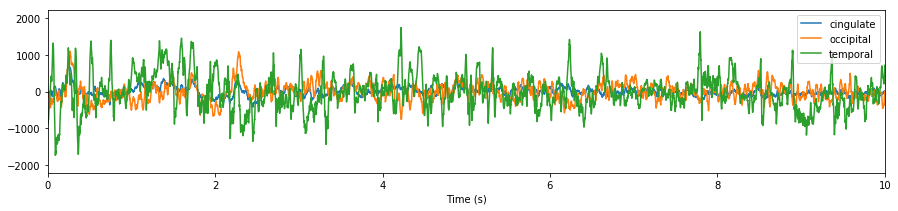

In [2]:
monkey_ecog_data = io.loadmat('ECoG_monkey/ECoG_monkey.mat', squeeze_me = True)
print(monkey_ecog_data.keys())
print(monkey_ecog_data['fs'])
print(monkey_ecog_data['ecog_eyesopen'].shape)
print(monkey_ecog_data['labels'])
print(monkey_ecog_data['elec_num'])

plt.figure(figsize=(15,3))
plt.plot(np.arange(0,monkey_ecog_data['ecog_eyesopen'].shape[1]/monkey_ecog_data['fs'],1/monkey_ecog_data['fs']), 
         monkey_ecog_data['ecog_eyesopen'].T)
plt.xlim([0,10])
plt.xlabel('Time (s)')
plt.legend(monkey_ecog_data['labels'])

In [3]:
# the following code will be used to assemble the appropriate code into a DataFrame
# so that it is a little easier to look at


# given labels and data
def to_DataFrame(state_data, label_data):
    # initialize temporary dictionary to poull from
    temp_dict = dict()
    
    # loop through values of length 3 (the 3 labels, occipital, cingulate, temporal)
    for i in range(len(label_data)):
        # store i-th label 
        label = label_data[i]
        # store i-th list (which has been converted into an np.array()
        temp_data = np.array(state_data[i,:])
        # store new label and item as a dictionary pair
        temp_dict[label] = temp_data

    # convert into DataFrame object
    as_DataFrame = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in temp_dict.items() ]))
    
    return as_DataFrame

ecog_open = to_DataFrame(monkey_ecog_data['ecog_eyesopen'], monkey_ecog_data['labels'].T )
ecog_close = to_DataFrame(monkey_ecog_data['ecog_eyesclosed'], monkey_ecog_data['labels'] )
ecog_anes = to_DataFrame(monkey_ecog_data['ecog_anes'], monkey_ecog_data['labels'] )


In [4]:
print(ecog_open.head())
print(ecog_close.head())
print(ecog_anes.head())
print(np.fft.fft(ecog_open['cingulate']))

   cingulate  occipital  temporal
0        -17       -117      -792
1        -28       -118      -826
2        -33       -100      -875
3        -19       -106      -843
4        -24       -110      -822
   cingulate  occipital  temporal
0        207        -32       -59
1        201         10       -64
2        205         26       -98
3        192         56      -108
4        188         68      -120
   cingulate  occipital  temporal
0         68       -634      -283
1         66       -627      -280
2         76       -618      -260
3         85       -610      -256
4         90       -607      -257
[373989.        -4.49825263e-13j 244564.9880785 -1.25279951e+04j
 -76972.83807645-1.14739833e+05j ... 206572.72219093+4.99655084e+04j
 -76972.83807645+1.14739833e+05j 244564.9880785 +1.25279951e+04j]


(300000,)


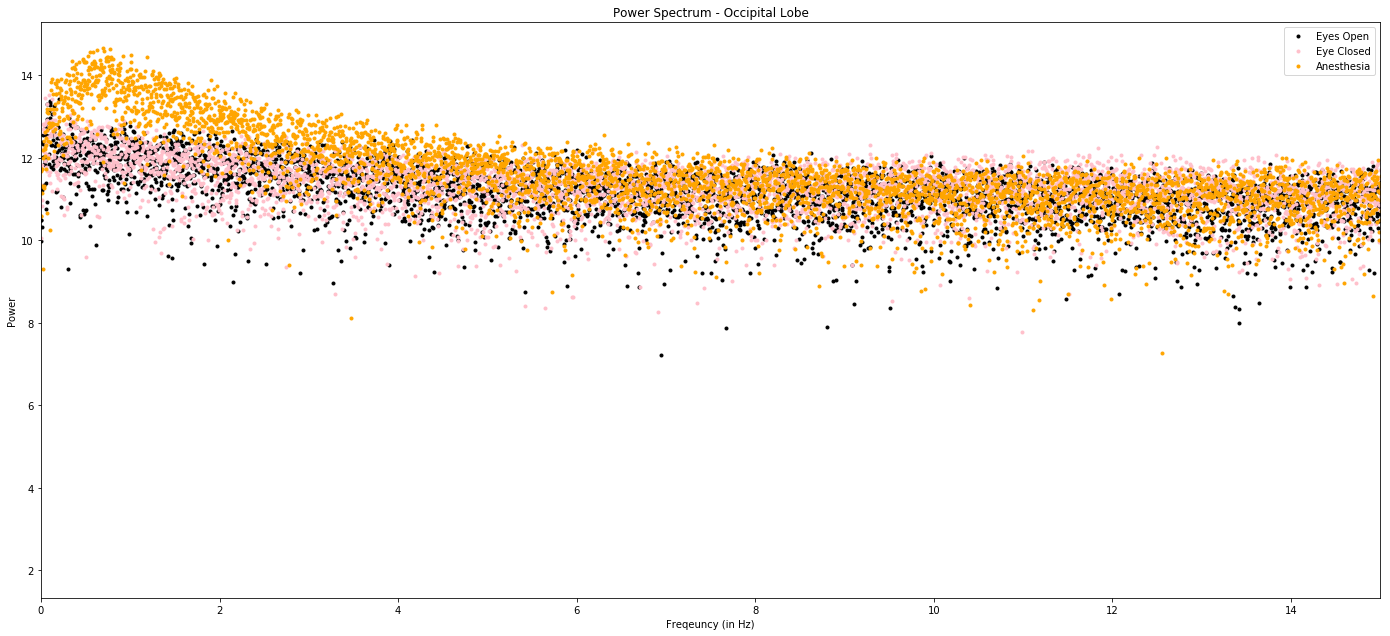

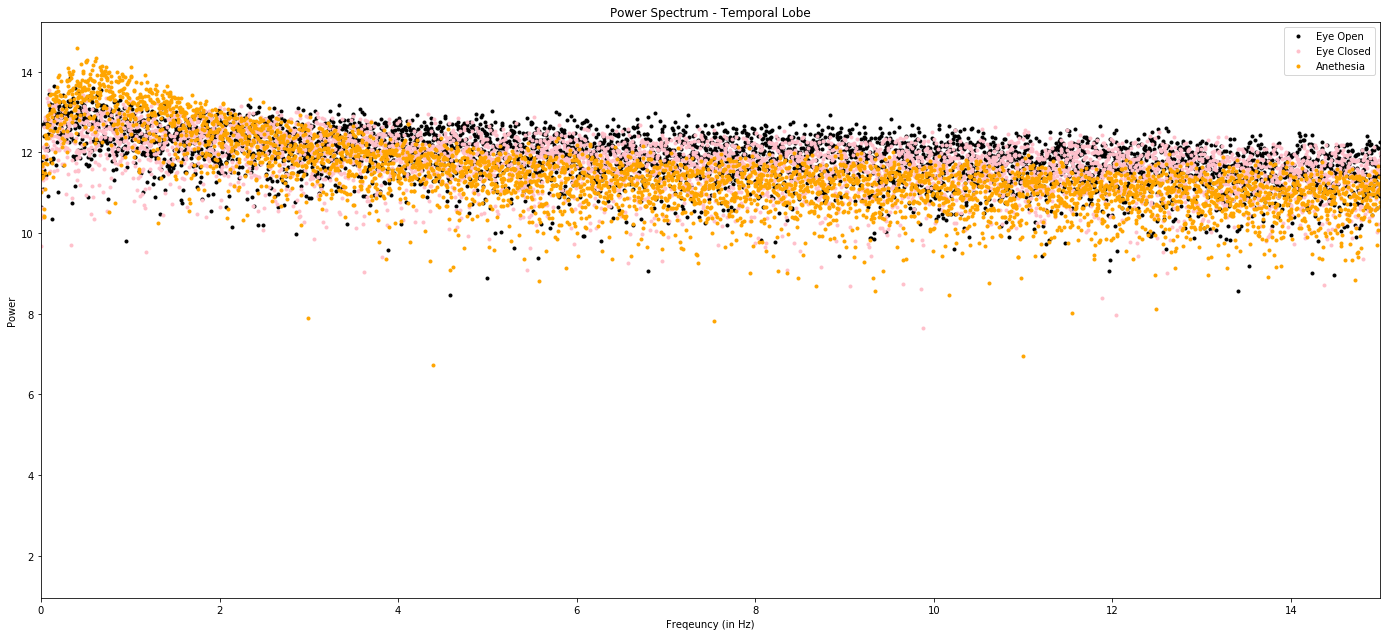

In [5]:
# intializing fs for our data
monkey_fs = monkey_ecog_data['fs']

# time vector in seconds
t_monkey = np.arange(0, 300, 1/monkey_fs )

freq_monkey = np.fft.fftfreq(300000, 1/monkey_fs)
print(freq_monkey.shape)

# compute FT of the DataFrame
# note that the inputs HAVE to be DataFrames
def compute_FT(state_data):
    # obtain column names of dataframes
    labels = list(state_data.columns.values)
    temp_dict = dict()
    
    for label in labels:
        temp_FT = np.fft.fft(state_data[label])
        # store label and item as a dictionary pair
        temp_dict[label] = temp_FT
        
    as_DataFrame = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in temp_dict.items() ]))
    
    return as_DataFrame
    
    
open_FT = compute_FT(ecog_open)
close_FT = compute_FT(ecog_close)
anes_FT = compute_FT(ecog_anes)


plt.figure(figsize = (24,36))
plt.subplot(3,1,1)
plt.plot(freq_monkey, np.log10(np.abs(open_FT['occipital'])**2), '.', label = 'Eyes Open', color = 'black')
plt.plot(freq_monkey, np.log10(np.abs(close_FT['occipital'])**2), '.', label = 'Eye Closed', color = 'pink')
plt.plot(freq_monkey, np.log10(np.abs(anes_FT['occipital'])**2), '.', label = 'Anesthesia', color = 'orange')
plt.xlim([0,15])
plt.title("Power Spectrum - Occipital Lobe")
plt.ylabel('Power'); plt.xlabel("Freqeuncy (in Hz)")
plt.legend()
plt.figure(figsize = (24,36))
plt.subplot(3,1,2)
temp_open_power = np.abs(open_FT['temporal']) **2
temp_close_power = np.abs(close_FT['temporal']) **2
temp_ane_power = np.abs(anes_FT['temporal']) **2
plt.plot(freq_monkey, np.log10(temp_open_power), '.', label = 'Eye Open', color = 'black')
plt.plot(freq_monkey, np.log10(temp_close_power), '.',label = 'Eye Closed', color = 'pink')
plt.plot(freq_monkey, np.log10(temp_ane_power), '.', label = 'Anethesia', color = 'orange')
plt.xlim([0,15])
plt.title("Power Spectrum - Temporal Lobe")
plt.ylabel('Power'); plt.xlabel("Freqeuncy (in Hz)")
plt.legend()



# Filtering Our Data

When observing the Power Spectrum that corresponds to the Occipital Lobe, we find that the occipital lobe generally has high activity at lower frequencies, from around 0 Hz to around 10 Hz. The Power Spectrum that corresponds to the Temporal Lobe shows that there is high activity from the frequencies 0 Hz to around 15 Hz. Lastly,  In the Cingulate Power Spectrum it generally shows that there is high activity from 0 Hz to around 8 Hz. We can thus use, these found frequencies to produce our bandpass filters.

In [28]:
# although the occipital and cingulate frequencies are higher by a little bit, the bulk of frequencies 
# found in the power spectrum data corresponds strongly with those of theta waves
occ_filt = signal.firwin( 30000, cutoff = 13, fs = monkey_fs, pass_zero = True)
temp_filt = signal.firwin( 30000, cutoff = 8, fs = monkey_fs, pass_zero = True)
spike_pass = signal.firwin(30000, cutoff = [30,100], fs = monkey_fs, pass_zero = False)

#convolve corresponding state data with appropriate filters

# occiptal convolution w/ occipital filter
occ_open_osc = np.convolve(ecog_open['occipital'], occ_filt, mode = 'same')
occ_close_osc = np.convolve(ecog_close['occipital'], occ_filt, mode = 'same')
occ_anes_osc = np.convolve(ecog_anes['occipital'], occ_filt, mode = 'same')

# temporal convolution w/ temporal filter
temp_open_osc = np.convolve(ecog_open['temporal'], temp_filt, mode = 'same')
temp_close_osc = np.convolve(ecog_close['temporal'], temp_filt, mode = 'same')
temp_anes_osc = np.convolve(ecog_anes['temporal'], temp_filt, mode = 'same')

# occiptal convolution w/ occipital filter
occ_open_spike = np.convolve(ecog_open['occipital'], spike_pass, mode = 'same')
occ_close_spike = np.convolve(ecog_close['occipital'], spike_pass, mode = 'same')
occ_anes_spike = np.convolve(ecog_anes['occipital'], spike_pass, mode = 'same')

# temporal convolution w/ temporal filter
temp_open_spike = np.convolve(ecog_open['temporal'], spike_pass, mode = 'same')
temp_close_spike = np.convolve(ecog_close['temporal'], spike_pass, mode = 'same')
temp_anes_spike = np.convolve(ecog_anes['temporal'], spike_pass, mode = 'same')


## Occipital Lobe Filter (smoothing)

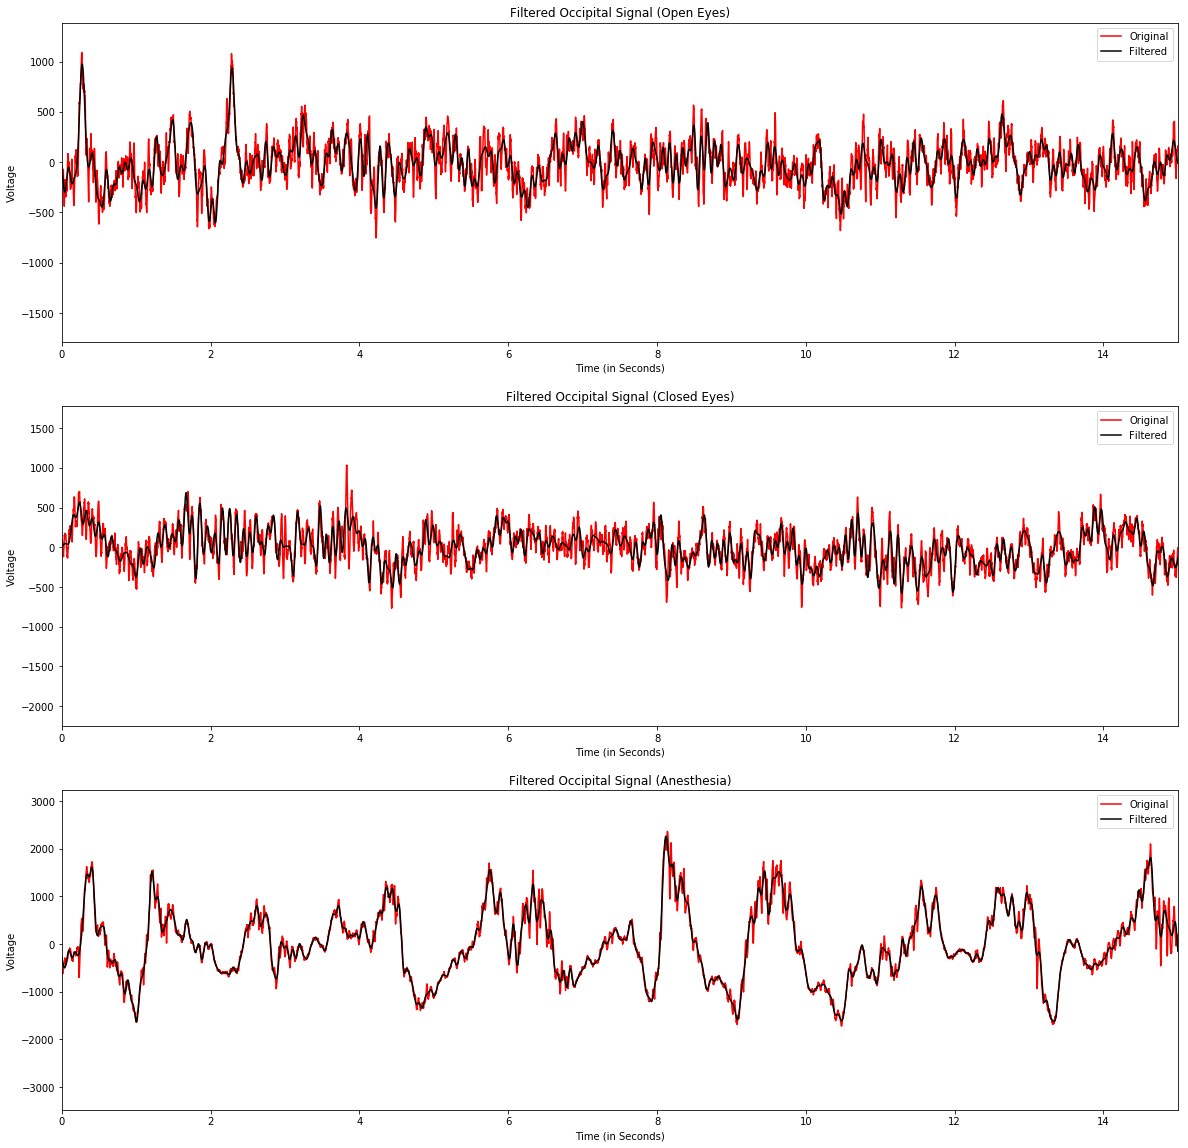

In [29]:
# plot the occipital signals and their filters

plt.figure(figsize = (20,20))

# occipital with opened eyes 
plt.subplot(3,1,1)
plt.plot(t_monkey, ecog_open['occipital'] , label = 'Original', color = 'red')
plt.plot(t_monkey, occ_open_osc, label = 'Filtered', color = 'black')
plt.xlim([0,15])
plt.title("Filtered Occipital Signal (Open Eyes)")
plt.ylabel('Voltage'); plt.xlabel("Time (in Seconds)")
plt.legend()

# occipital with closed eyes
plt.subplot(3,1,2)
plt.plot(t_monkey, ecog_close['occipital'] , label = 'Original', color = 'red')
plt.plot(t_monkey, occ_close_osc, label = 'Filtered', color = 'black')
plt.xlim([0,15])
plt.title("Filtered Occipital Signal (Closed Eyes)")
plt.ylabel('Voltage'); plt.xlabel("Time (in Seconds)")
plt.legend()
plt.subplot(3,1,3)

# occipital with anesthesia
plt.plot(t_monkey, ecog_anes['occipital'] , label = 'Original', color = 'red')
plt.plot(t_monkey, occ_anes_osc, label = 'Filtered', color = 'black')
plt.xlim([0,15])
plt.title("Filtered Occipital Signal (Anesthesia)")
plt.ylabel('Voltage'); plt.xlabel("Time (in Seconds)")
plt.legend()

## Temporal Lobe Filter (smoothing)

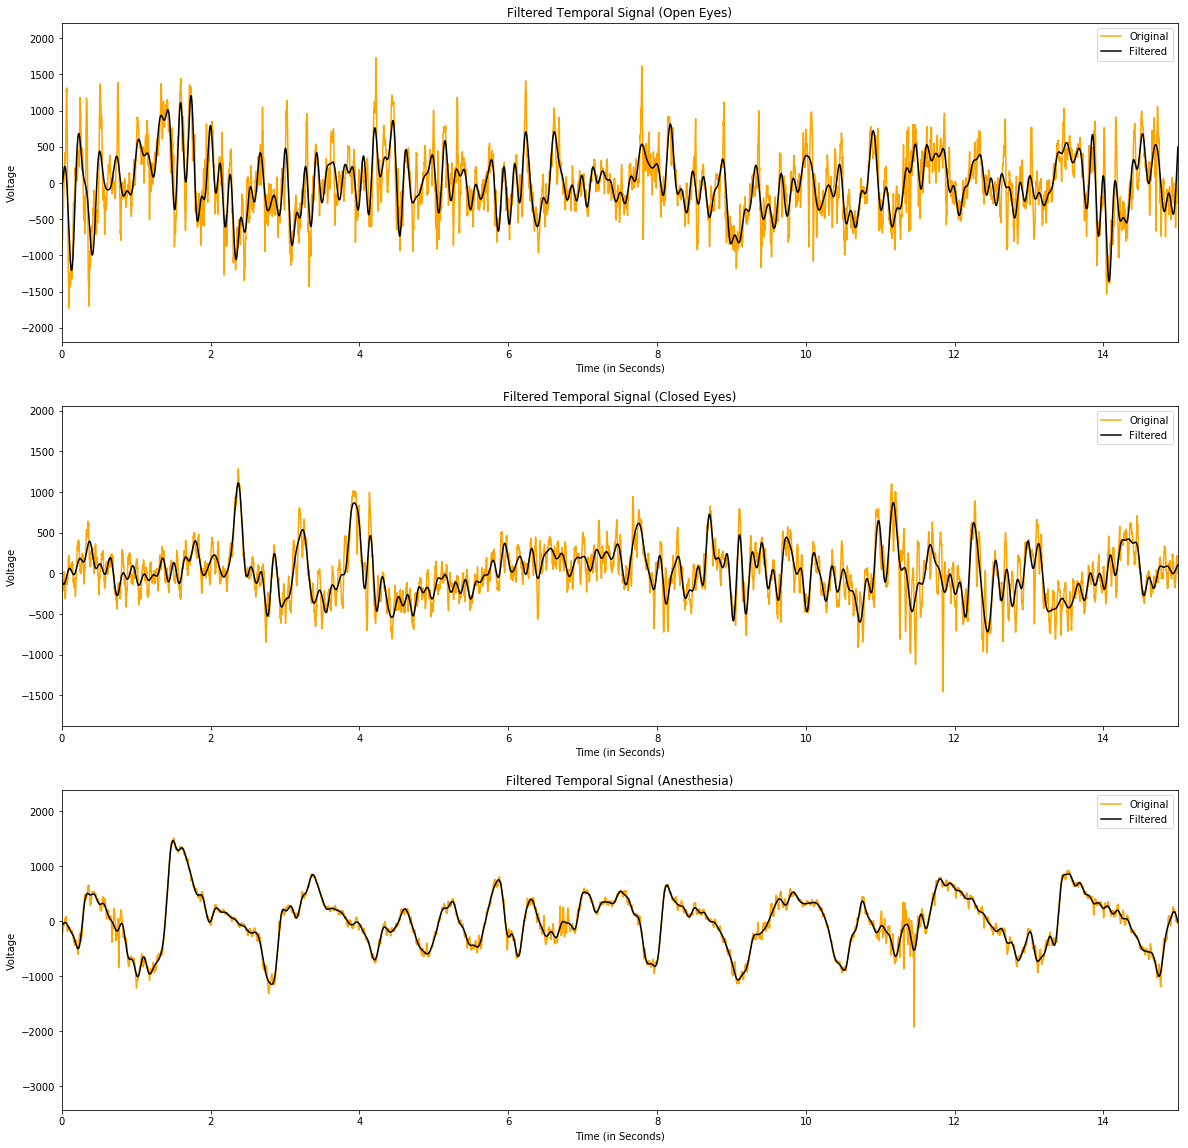

In [30]:
# plot the temporal signals and their filters

plt.figure(figsize = (20,20))

# temporal with opened eyes 
plt.subplot(3,1,1)
plt.plot(t_monkey, ecog_open['temporal'] , label = 'Original', color = 'orange')
plt.plot(t_monkey, temp_open_osc, label = 'Filtered', color = 'black')
plt.xlim([0,15])
plt.title("Filtered Temporal Signal (Open Eyes)")
plt.ylabel('Voltage'); plt.xlabel("Time (in Seconds)")
plt.legend()

# temporal with closed eyes
plt.subplot(3,1,2)
plt.plot(t_monkey, ecog_close['temporal'] , label = 'Original', color = 'orange')
plt.plot(t_monkey, temp_close_osc, label = 'Filtered', color = 'black')
plt.xlim([0,15])
plt.title("Filtered Temporal Signal (Closed Eyes)")
plt.ylabel('Voltage'); plt.xlabel("Time (in Seconds)")
plt.legend()
plt.subplot(3,1,3)

# temporal with anesthesia
plt.plot(t_monkey, ecog_anes['temporal'] , label = 'Original', color = 'orange')
plt.plot(t_monkey, temp_anes_osc, label = 'Filtered', color = 'black')
plt.xlim([0,15])
plt.title("Filtered Temporal Signal (Anesthesia)")
plt.ylabel('Voltage'); plt.xlabel("Time (in Seconds)")
plt.legend()

## Occipital Lobe Filter (Spiking)

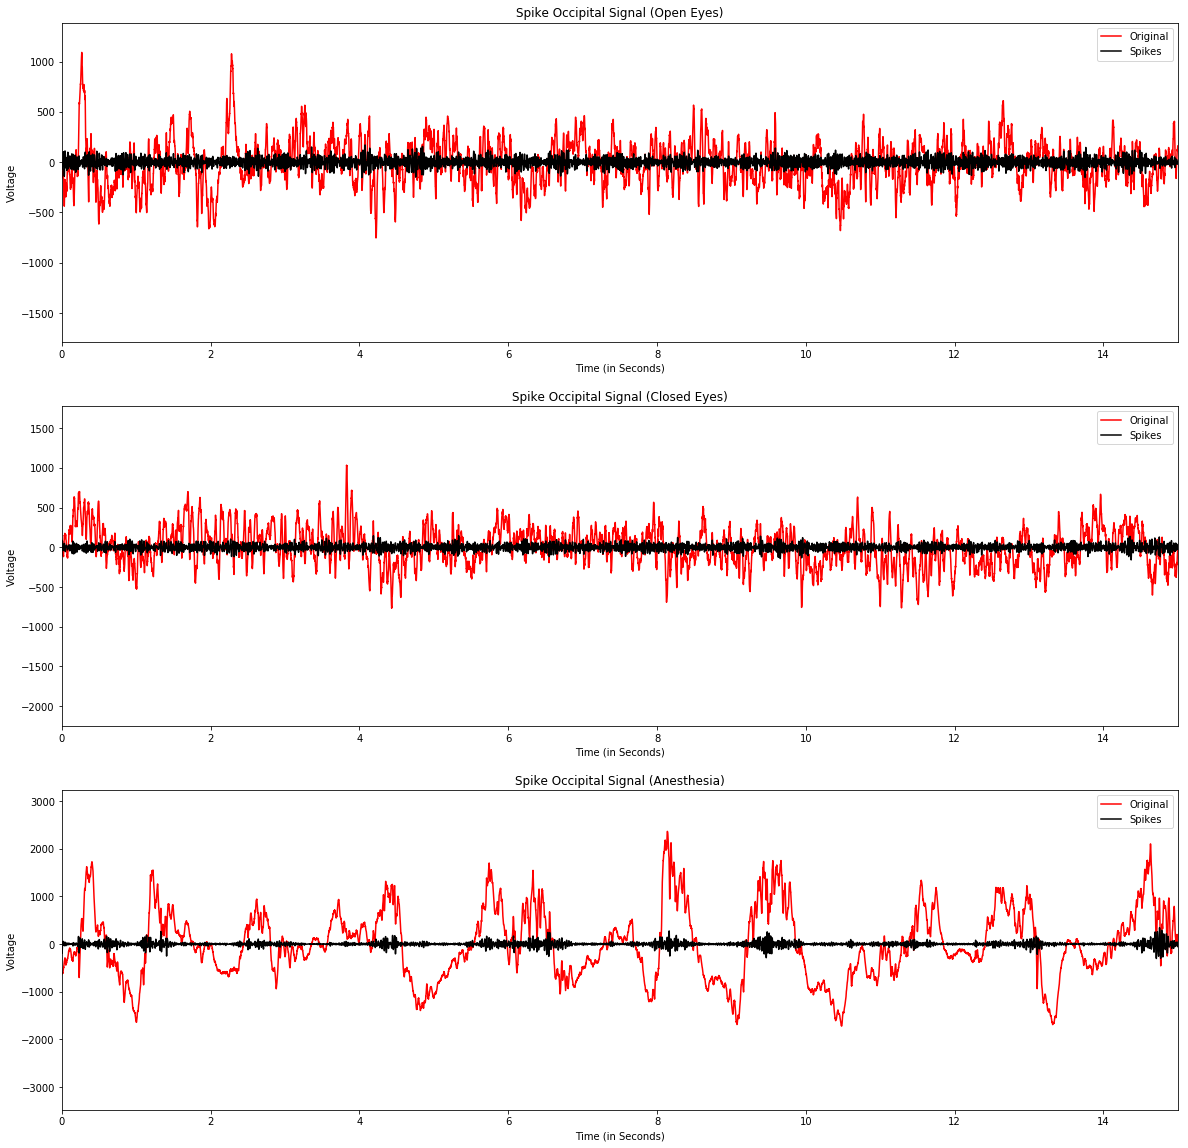

In [31]:
# plot the occipital signals and their filters

plt.figure(figsize = (20,20))

# occipital with opened eyes 
plt.subplot(3,1,1)
plt.plot(t_monkey, ecog_open['occipital'] , label = 'Original', color = 'red')
plt.plot(t_monkey, occ_open_spike, label = 'Spikes', color = 'black')
plt.xlim([0,15])
plt.title("Spike Occipital Signal (Open Eyes)")
plt.ylabel('Voltage'); plt.xlabel("Time (in Seconds)")
plt.legend()

# occipital with closed eyes
plt.subplot(3,1,2)
plt.plot(t_monkey, ecog_close['occipital'] , label = 'Original', color = 'red')
plt.plot(t_monkey, occ_close_spike, label = 'Spikes', color = 'black')
plt.xlim([0,15])
plt.title("Spike Occipital Signal (Closed Eyes)")
plt.ylabel('Voltage'); plt.xlabel("Time (in Seconds)")
plt.legend()
plt.subplot(3,1,3)

# occipital with anesthesia
plt.plot(t_monkey, ecog_anes['occipital'] , label = 'Original', color = 'red')
plt.plot(t_monkey, occ_anes_spike, label = 'Spikes', color = 'black')
plt.xlim([0,15])
plt.title("Spike Occipital Signal (Anesthesia)")
plt.ylabel('Voltage'); plt.xlabel("Time (in Seconds)")
plt.legend()

## Occipital Lobe Filter (Spiking)

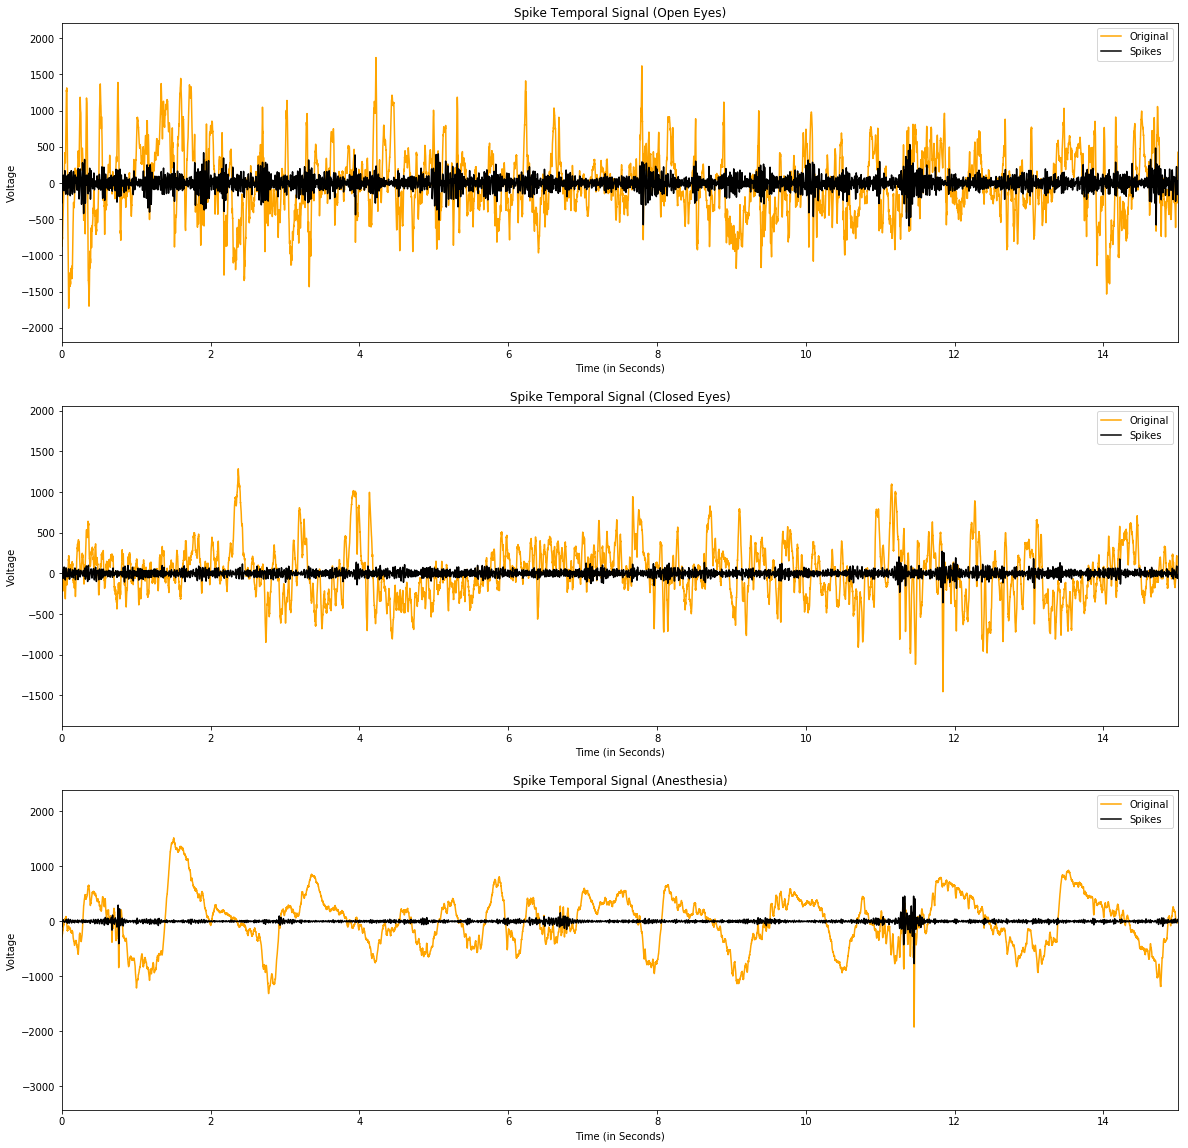

In [32]:
# plot the temporal signals and their filters

plt.figure(figsize = (20,20))

# temporal with opened eyes 
plt.subplot(3,1,1)
plt.plot(t_monkey, ecog_open['temporal'] , label = 'Original', color = 'orange')
plt.plot(t_monkey, temp_open_spike, label = 'Spikes', color = 'black')
plt.xlim([0,15])
plt.title("Spike Temporal Signal (Open Eyes)")
plt.ylabel('Voltage'); plt.xlabel("Time (in Seconds)")
plt.legend()

# temporal with closed eyes
plt.subplot(3,1,2)
plt.plot(t_monkey, ecog_close['temporal'] , label = 'Original', color = 'orange')
plt.plot(t_monkey, temp_close_spike, label = 'Spikes', color = 'black')
plt.xlim([0,15])
plt.title("Spike Temporal Signal (Closed Eyes)")
plt.ylabel('Voltage'); plt.xlabel("Time (in Seconds)")
plt.legend()
plt.subplot(3,1,3)

# temporal with anesthesia
plt.plot(t_monkey, ecog_anes['temporal'] , label = 'Original', color = 'orange')
plt.plot(t_monkey, temp_anes_spike, label = 'Spikes', color = 'black')
plt.xlim([0,15])
plt.title("Spike Temporal Signal (Anesthesia)")
plt.ylabel('Voltage'); plt.xlabel("Time (in Seconds)")
plt.legend()

## Computing Hilbert Transforms

In [58]:
# occiptal convolution w/ occipital filter
#occ_open_osc = np.convolve(ecog_open['occipital'], occ_filt, mode = 'same')
#occ_close_osc = np.convolve(ecog_close['occipital'], occ_filt, mode = 'same')
#occ_anes_osc = np.convolve(ecog_anes['occipital'], occ_filt, mode = 'same')

# temporal convolution w/ temporal filter
#temp_open_osc = np.convolve(ecog_open['temporal'], temp_filt, mode = 'same')
#temp_close_osc = np.convolve(ecog_close['temporal'], temp_filt, mode = 'same')
#temp_anes_osc = np.convolve(ecog_anes['temporal'], temp_filt, mode = 'same')

def compute_power_phase(x_a):
    # _FILL_IN_YOUR_CODE_HERE
    power = np.abs(x_a)**2
    phase = np.angle(x_a)
    
    return power, phase

# compute occipital analytic signal
x_a_occ_open = signal.hilbert(occ_open_osc)
x_a_occ_close = signal.hilbert(occ_close_osc)
x_a_occ_anes = signal.hilbert(occ_anes_osc)

# compute temporal analytic signal
x_a_temp_open = signal.hilbert(temp_open_osc)
x_a_temp_close = signal.hilbert(temp_close_osc)
x_a_temp_anes = signal.hilbert(temp_anes_osc)

# compute occipital power and phase
occ_open_power, occ_open_phase = compute_power_phase(x_a_occ_open)
occ_close_power, occ_close_phase = compute_power_phase(x_a_occ_close)
occ_anes_power, occ_anes_phase = compute_power_phase(x_a_occ_anes)

# compute temporal power and phase
temp_open_power, temp_open_phase = compute_power_phase(x_a_temp_open)
temp_close_power, temp_close_phase = compute_power_phase(x_a_temp_close)
temp_anes_power, temp_anes_phase = compute_power_phase(x_a_temp_anes)

## Occipital Lobe Analytic Signals

Text(0.5, 1.0, 'Occipital Analytic Signal (Anesthesia)')

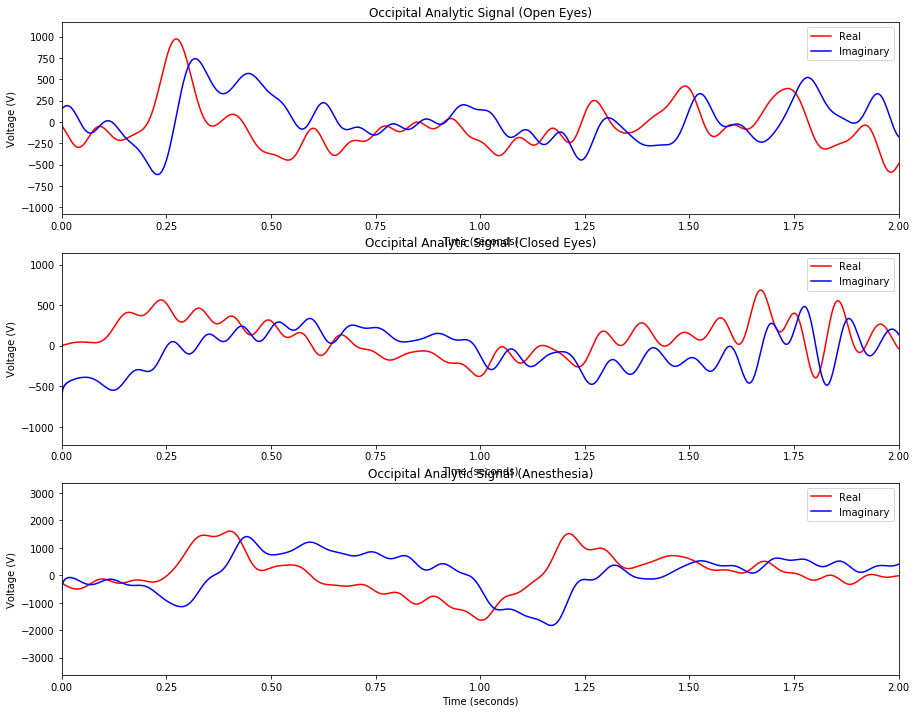

In [59]:
# plot the necessary graphs for occipital analytic signals

plt.figure(figsize=(15,12))

plt.subplot(3,1,1)
# occipital real
plt.plot(t_monkey, x_a_occ_open.real, label = "Real", color = 'red')
plt.plot(t_monkey, x_a_occ_open.imag, label = "Imaginary", color = 'Blue')
plt.xlabel("Time (seconds)"); plt.ylabel("Voltage (V)")
plt.xlim([0,2]); plt.legend(); plt.title("Occipital Analytic Signal (Open Eyes)")

plt.subplot(3,1,2)
# occipital Imaginary
plt.plot(t_monkey, x_a_occ_close.real, label = "Real", color = 'red')
plt.plot(t_monkey, x_a_occ_close.imag, label = "Imaginary", color = 'blue')
plt.xlabel("Time (seconds)"); plt.ylabel("Voltage (V)")
plt.xlim([0,2]); plt.legend(); plt.title("Occipital Analytic Signal (Closed Eyes)")

plt.subplot(3,1,3)
plt.plot(t_monkey, x_a_occ_anes.real, label = "Real", color = 'red')
plt.plot(t_monkey, x_a_occ_anes.imag, label = "Imaginary", color = 'blue')
plt.xlabel("Time (seconds)"); plt.ylabel("Voltage (V)")
plt.xlim([0,2]); plt.legend(); plt.title("Occipital Analytic Signal (Anesthesia)")

## Temporal Lobe Analytic Signals

Text(0.5, 1.0, 'Temporal Analytic Signal (Anesthesia)')

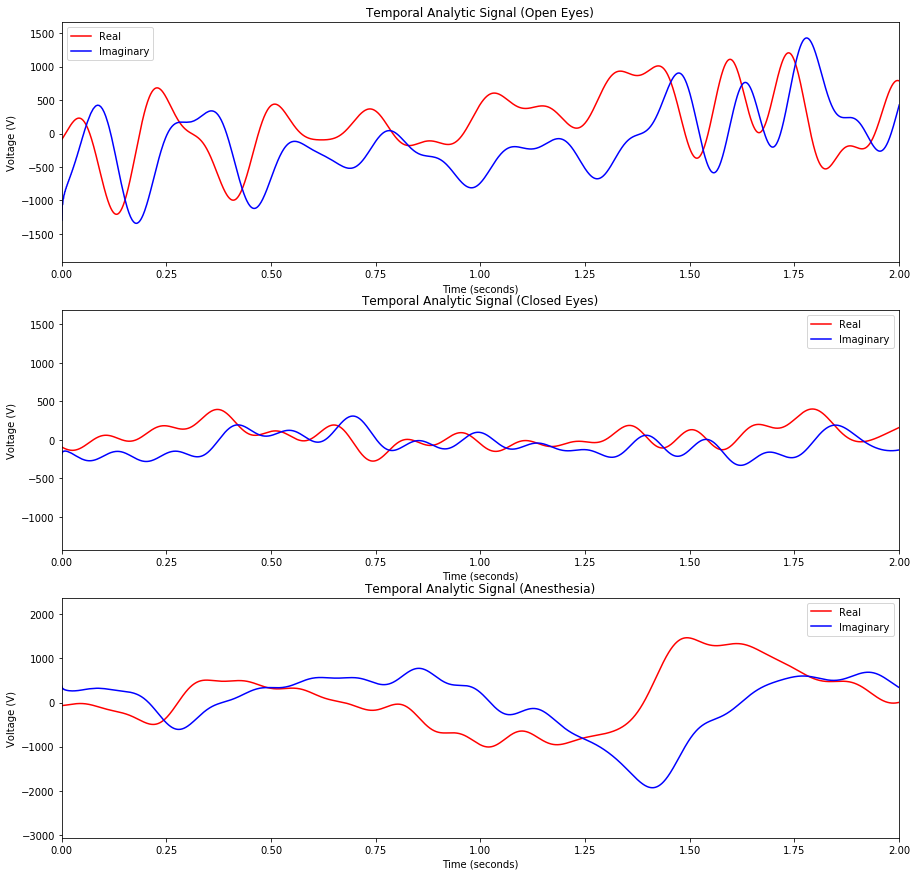

In [60]:
# plot the necessary graphs for occipital analytic signals

plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
# occipital real
plt.plot(t_monkey, x_a_temp_open.real, label = "Real", color = 'red')
plt.plot(t_monkey, x_a_temp_open.imag, label = "Imaginary", color = 'Blue')
plt.xlabel("Time (seconds)"); plt.ylabel("Voltage (V)")
plt.xlim([0,2]); plt.legend(); plt.title("Temporal Analytic Signal (Open Eyes)")

plt.subplot(3,1,2)
# occipital Imaginary
plt.plot(t_monkey, x_a_temp_close.real, label = "Real", color = 'red')
plt.plot(t_monkey, x_a_temp_close.imag, label = "Imaginary", color = 'blue')
plt.xlabel("Time (seconds)"); plt.ylabel("Voltage (V)")
plt.xlim([0,2]); plt.legend(); plt.title("Temporal Analytic Signal (Closed Eyes)")

plt.subplot(3,1,3)
plt.plot(t_monkey, x_a_temp_anes.real, label = "Real", color = 'red')
plt.plot(t_monkey, x_a_temp_anes.imag, label = "Imaginary", color = 'blue')
plt.xlabel("Time (seconds)"); plt.ylabel("Voltage (V)")
plt.xlim([0,2]); plt.legend(); plt.title("Temporal Analytic Signal (Anesthesia)")

## Phase Amplitude Coupling Anesthesia

[-2.04192446 -2.26031975 -2.30883868 ... -2.46423327 -2.46133779
 -2.31307386]
[144466.76441393 110008.82084241 109604.00261533 ... 105938.92931095
 105678.53013306 139736.04882229]


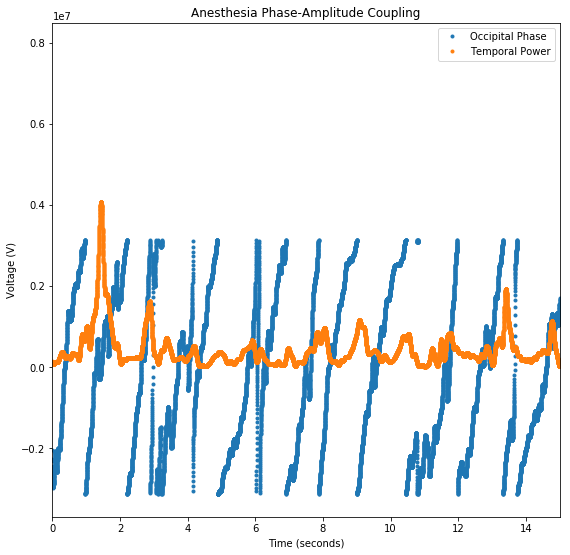

In [72]:
# plot amplitude phase coupling

peak_inds = np.where(np.logical_and(occ_open_phase>-np.pi/2, occ_open_phase<np.pi/2))[0]
trough_inds = np.where(np.logical_or(occ_open_phase<-np.pi/2, occ_open_phase>np.pi/2))[0]

plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
# open eyes
# plot the theta peak and trough phases
plt.plot(t_monkey, occ_anes_phase * 1000000, '.', label = 'Occipital Phase')
plt.plot(t_monkey, temp_anes_power, '.', label = 'Temporal Power')
plt.xlabel("Time (seconds)"); plt.ylabel("Voltage (V)")
plt.xlim([0,15]); plt.legend(); plt.title("Anesthesia Phase-Amplitude Coupling")

[1.82252459 1.87347934 1.89611926 ... 1.68142043 1.66074278 1.63385624]
[1683838.97108894 1153833.61679619 1129194.69882294 ... 1490840.69200081
 1449361.89651523 1907035.54719398]


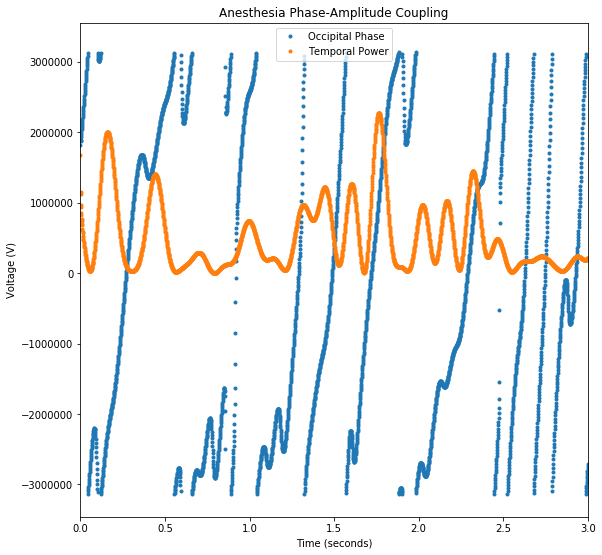

In [73]:
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
# open eyes
# plot the theta peak and trough phases
plt.plot(t_monkey, occ_open_phase * 1000000, '.', label = 'Occipital Phase')
plt.plot(t_monkey, temp_open_power, '.', label = 'Temporal Power')
plt.xlabel("Time (seconds)"); plt.ylabel("Voltage (V)")
plt.xlim([0,3]); plt.legend(); plt.title("Open Eyes Phase-Amplitude Coupling")

[1.82252459 1.87347934 1.89611926 ... 1.68142043 1.66074278 1.63385624]
[1683838.97108894 1153833.61679619 1129194.69882294 ... 1490840.69200081
 1449361.89651523 1907035.54719398]


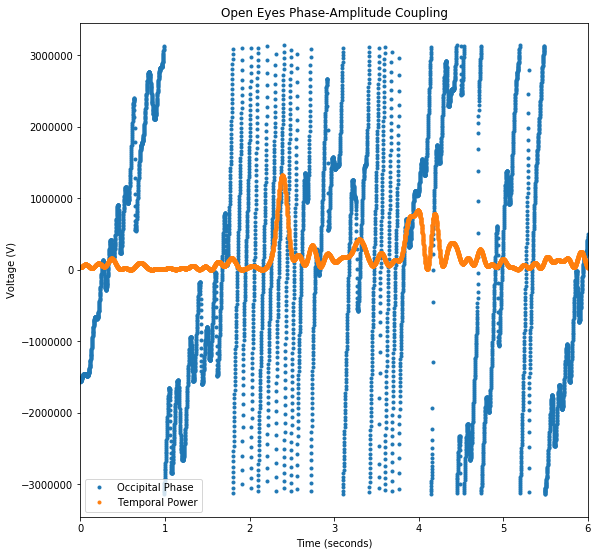

In [77]:
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
# open eyes
# plot the theta peak and trough phases
plt.plot(t_monkey, occ_close_phase * 1000000, '.', label = 'Occipital Phase')
plt.plot(t_monkey, temp_close_power, '.', label = 'Temporal Power')
plt.xlabel("Time (seconds)"); plt.ylabel("Voltage (V)")
plt.xlim([0,6]); plt.legend(); plt.title("Closed Eyes Phase-Amplitude Coupling")

In [ ]:
def plot_spectrogram(spg, t, f, freq_lims=[0,100], plot_db=False):
    """
    Utility function for plotting the spectrogram for you.
    
    spg: spectrogram, 2D real-numbered array, dimensions are [frequency x time]
    t: time axis of spectrogram
    f: frequency axis of spectrogram
    freq_lims (optional): limits the frequency axis, defaults to 0-100Hz
    """
    plt.figure(figsize=(15,4))
    if plot_db:
        plt.imshow(10*np.log10(spg), aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    else:
        plt.imshow(spg, aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    plt.xlabel('Time'); plt.ylabel('Frequency(Hz)');
    plt.ylim(freq_lims)
    plt.colorbar()
    plt.tight_layout()

def slide_window_time(T,len_win,len_overlap):
    # T is total signal time, len_win is window length in seconds, len_overlap is overlap length in seconds
    time = 0
    t_steps = []
    #while the timestamp is at least len_win less than the total time append the time
    while (time + len_win) <= T:
        t_steps.append(time)
        time = time + (len_win - len_overlap)
    t_steps = np.array(t_steps)
    return t_steps
    
def slide_window_index(T,fs,len_win,len_overlap):
    ti = slide_window_time(T, len_win, len_overlap)
    index = ti*fs
    index = np.array(index).astype(int)
    return index
  
    
def my_stft(data, fs, len_win, len_overlap):
    T = data.size/fs
    inds_stft = slide_window_index(T,fs,len_win,len_overlap)
    t_stft = slide_window_time(T, len_win, len_overlap)
    f_stft = np.fft.fftfreq(int(len_win*fs), 1/fs)
    stft = np.array([np.fft.fft(data[i:i+int(len_win*fs)]) for i in inds_stft])
    stft = stft.T

    # clip the frequency axis to return just the non-negative frequencies
    # np.fft.fftfreq returns the nyquist frequency as negative, which we also need to keep
    positive_fs = np.logical_or(f_stft>=0, f_stft==-fs/2)    
    
    # I return for you just the positive frequencies 
    return abs(f_stft[positive_fs]), t_stft, stft[positive_fs, :]

In [ ]:
len_win = 5
len_overlap = 1


f_stft, t_stft, stft = my_stft(ecog_open['temporal'], monkey_fs, len_win, len_overlap)
spg = np.abs(stft)**2
psd_open_temp = spg.mean(axis = 1)
plot_spectrogram(spg, t_stft, f_stft, freq_lims=[0,10], plot_db=False)
plt.title('My Spectrogram Temporal Open')


len_win = 5
len_overlap = 1

f_stft, t_stft, stft = my_stft(ecog_close['temporal'], monkey_fs, len_win, len_overlap)
spg = np.abs(stft)**2
psd_close_temp = spg.mean(axis = 1)
plot_spectrogram(spg, t_stft, f_stft, freq_lims=[0,10], plot_db=False)
plt.title('My Spectrogram Temporal Closed')



len_win = 5
len_overlap = 1

f_stft, t_stft, stft = my_stft(ecog_anes['temporal'], monkey_fs, len_win, len_overlap)
spg = np.abs(stft)**2
psd_anes_temp = spg.mean(axis = 1)
plot_spectrogram(spg, t_stft, f_stft, freq_lims=[0,10], plot_db=False)
plt.title('My Spectrogram Temporal Anes')





In [ ]:
len_win = 5
len_overlap = 1


f_stft, t_stft, stft = my_stft(ecog_open['occipital'], monkey_fs, len_win, len_overlap)
spg = np.abs(stft)**2
psd_open_occi = spg.mean(axis = 1)
plot_spectrogram(spg, t_stft, f_stft, freq_lims=[0,10], plot_db=False)
plt.title('My Spectrogram Occipital Open')


len_win = 5
len_overlap = 1

f_stft, t_stft, stft = my_stft(ecog_close['occipital'], monkey_fs, len_win, len_overlap)
spg = np.abs(stft)**2
psd_close_occi = spg.mean(axis = 1)
plot_spectrogram(spg, t_stft, f_stft, freq_lims=[0,10], plot_db=False)
plt.title('My Spectrogram Occipital Closed')



len_win = 5
len_overlap = 1

f_stft, t_stft, stft = my_stft(ecog_anes['occipital'], monkey_fs, len_win, len_overlap)
spg = np.abs(stft)**2
psd_anes_occi = spg.mean(axis = 1)
plot_spectrogram(spg, t_stft, f_stft, freq_lims=[0,10], plot_db=False)
plt.title('My Spectrogram Occipital Anes')





# Creating Our Spectrograms

When we first initialized creating our Short Time Fourier Transform, we decided that we wanted to focus on getting a better frequency resolution rather than time resolution, so we set our window length to be 5 seconds each. Then we plotted our Short Time Fourier Transform into the seen spectrograms. 

Based on these spectrograms, we observe that for the state of Anesthesia the monkeys have ECoG measurements at very low frequencies that usually ranged from 0 Hz to around 2 Hz maximum. This indicates that brain activity is very low in temporal and occipital lobes during a state of Anesthesia.





In [ ]:
# plot the PSDs
plt.figure(figsize=(15,15))
plt.plot(f_stft, np.log10(psd_open_temp), label = 'PSD Temporal Open', color = 'black')
plt.plot(f_stft, np.log10(psd_close_temp), label = 'PSD Temporal Closed', color = 'red')
plt.plot(f_stft, np.log10(psd_anes_temp), label = 'PSD Temporal Anes', color = 'blue')
plt.xlim([0,20])
plt.xlabel('Freq (Hz)')
plt.ylabel('Power')
plt.legend()

# plot the PSDs
plt.figure(figsize=(15,15))
plt.plot(f_stft, np.log10(psd_open_occi), label = 'PSD Occipital Open', color = 'black')
plt.plot(f_stft, np.log10(psd_close_occi), label = 'PSD Occipital Closed', color = 'red')
plt.plot(f_stft, np.log10(psd_anes_occi), label = 'PSD Occipital Anes', color = 'blue')
plt.xlim([0,50])
plt.xlabel('Freq (Hz)')
plt.ylabel('Power')
plt.legend()